# Initialization

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from PIL import Image
from pyquaternion import Quaternion
import numpy as np
import cv2
import time

#nuScenes devkit library
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, Box
from nuscenes.utils.geometry_utils import box_in_image
from nuscenes.utils.geometry_utils import BoxVisibility, transform_matrix

In [ ]:
nusc = NuScenes(version='v1.0-mini', dataroot='./mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.307 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


# Get scene, check log

In [3]:
#nusc.scene : 하나의 주행 세션 여러개의 sample로 구성됨
my_scene = nusc.scene[0]
my_scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [4]:
nusc.get('log', my_scene['log_token'])

{'token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'logfile': 'n015-2018-07-24-11-22-45+0800',
 'vehicle': 'n015',
 'date_captured': '2018-07-24',
 'location': 'singapore-onenorth',
 'map_token': '53992ee3023e5494b90c316c183be829'}

In [5]:
first_sample_token = my_scene['first_sample_token']
sample = nusc.get('sample', first_sample_token)
sample

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

# Play Scene in Video

In [6]:
##########################################################################
#                     TODO: Implement line                               #
##########################################################################
# Replace "..." statement with your code
# 몇 번째 scene을 visualize 할 것인지
scene_token = nusc.scene[0]['token']
###########################################################################
#                            END OF YOUR CODE                             #
###########################################################################

imsize= (320,180)

scene_rec = nusc.get('scene', scene_token)
first_sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
last_sample_rec = nusc.get('sample', scene_rec['last_sample_token'])

layout = {
    'CAM_FRONT_LEFT': (0, 0),
    'CAM_FRONT': (imsize[0], 0),
    'CAM_FRONT_RIGHT': (2 * imsize[0], 0),
    'CAM_BACK_LEFT': (0, imsize[1]),
    'CAM_BACK': (imsize[0], imsize[1]),
    'CAM_BACK_RIGHT': (2 * imsize[0], imsize[1]),
}

horizontal_flip = ['CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'] 

time_step = 1 / 10 * 1e6

### get box, sample data

In [7]:
def get_box(sample_annotation_token):
    #Sample 의 annotation 가져오기 (bbox)
    record = nusc.get('sample_annotation', sample_annotation_token)
    return Box(record['translation'], record['size'], Quaternion(record['rotation']),
                name=record['category_name'], token=record['token'])

def get_sample_data(sd_rec):
    # Retrieve sensor & pose records
    sd_record = nusc.get('sample_data', sd_rec['token'])
    cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc.get('sensor', cs_record['sensor_token'])
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])
    data_path = os.path.join(nusc.dataroot, sd_record['filename'])
    cam_intrinsic = np.array(cs_record['camera_intrinsic'])
    imsize = (sd_record['width'], sd_record['height'])

    curr_sample_record = nusc.get('sample', sd_record['sample_token'])

    #scene의 첫 sample이거나 key_frame이면
    if curr_sample_record['prev'] == "" or sd_record['is_key_frame']:
        boxes = list(map(get_box, curr_sample_record['anns']))
    else: #Scene의 중간 sample 이면
        prev_sample_record = nusc.get('sample', curr_sample_record['prev'])
        #각각의 sample_record에 있는 모든 token 모두 list화 
        curr_ann_recs = [nusc.get('sample_annotation', token) for token in curr_sample_record['anns']]
        prev_ann_recs = [nusc.get('sample_annotation', token) for token in prev_sample_record['anns']]

        # Maps instance tokens to prev_ann records
        prev_inst_map = {entry['instance_token']: entry for entry in prev_ann_recs}

        t0 = prev_sample_record['timestamp'] #이전 sample 의 timestamp
        t1 = curr_sample_record['timestamp'] #현재 sample 의 timestamp
        t = sd_record['timestamp'] #sample 사이 t
        
        # There are rare situations where the timestamps in the DB are off so ensure that t0 < t < t1.
        t = max(t0, min(t1, t))

        boxes = []
        for curr_ann_rec in curr_ann_recs:

            if curr_ann_rec['instance_token'] in prev_inst_map:
                # If the annotated instance existed in the previous frame, 해당 instance가져오고 interpolate center & orientation.
                prev_ann_rec = prev_inst_map[curr_ann_rec['instance_token']]

                # Interpolate center.Because only samples are annotated (0.5초)
                # linear motion expected -> 가끔씩 bbox가 벗어남
                center = [np.interp(t, [t0, t1], [c0, c1]) for c0, c1 in zip(prev_ann_rec['translation'],
                                                                                curr_ann_rec['translation'])]

                # Interpolate orientation.
                rotation = Quaternion.slerp(q0=Quaternion(prev_ann_rec['rotation']),
                                            q1=Quaternion(curr_ann_rec['rotation']),
                                            amount=(t - t0) / (t1 - t0))

                box = Box(center, curr_ann_rec['size'], rotation, name=curr_ann_rec['category_name'],
                            token=curr_ann_rec['token'])
            else:
                # If not, simply grab the current annotation.
                box = get_box(curr_ann_rec['token'])

            boxes.append(box)

    # Make list of Box objects including coord system transforms.
    # bbox 정렬 with translation, rotation matrix
    box_list = []
    for box in boxes:

        # Move box to ego vehicle coord system.
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system.
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        #Check if a box is visible inside an image without accounting for occlusions.
        if sensor_record['modality'] == 'camera' and not \
            box_in_image(box, cam_intrinsic, imsize, vis_level=BoxVisibility.ANY):
            continue

        box_list.append(box)

    return data_path, box_list, cam_intrinsic

In [8]:
# video setting
output_file = 'scene_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 10
frame_width = 3 * imsize[0]
frame_height = 2 * imsize[1]
out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

In [9]:
# This cell takes about 40s
canvas = np.ones((2 * imsize[1], 3 * imsize[0], 3), np.uint8)
current_recs = {}  
prev_recs = {}
for channel in layout: #Channel : Camera View 
    current_recs[channel] = nusc.get('sample_data', first_sample_rec['data'][channel])
    prev_recs[channel] = None

current_time = first_sample_rec['timestamp']
while current_time < last_sample_rec['timestamp']: #시간으로 while문 지속
    current_time += time_step

    for channel, sd_rec in current_recs.items():
        #next sample record 추가
        while sd_rec['timestamp'] < current_time and sd_rec['next'] != '': 
            sd_rec = nusc.get('sample_data', sd_rec['next'])
            current_recs[channel] = sd_rec # dic {channel: sd_rec}

    for channel, sd_rec in current_recs.items():
        if not sd_rec == prev_recs[channel]:
            impath, box_list, camera_intrinsic = get_sample_data(sd_rec)
            im = cv2.imread(impath)
            for box in box_list:
                c = nusc.colormap[box.name] #각각 class마다 이미 color가 있고 그걸 활용
                box.render_cv2(im, view=camera_intrinsic, normalize=True, colors=(c, c, c))

            im = cv2.resize(im, imsize)
            if channel in horizontal_flip: #뒤에 달려있는 카메라들은 가시성을 위해 뒤집기
                im = im[:, ::-1, :]

            canvas[
                layout[channel][1]: layout[channel][1] + imsize[1],
                layout[channel][0]:layout[channel][0] + imsize[0], :
            ] = im

            prev_recs[channel] = sd_rec
    time.sleep(0.01)
    out.write(canvas)
out.release()

# Render point cloud in image by built-in method

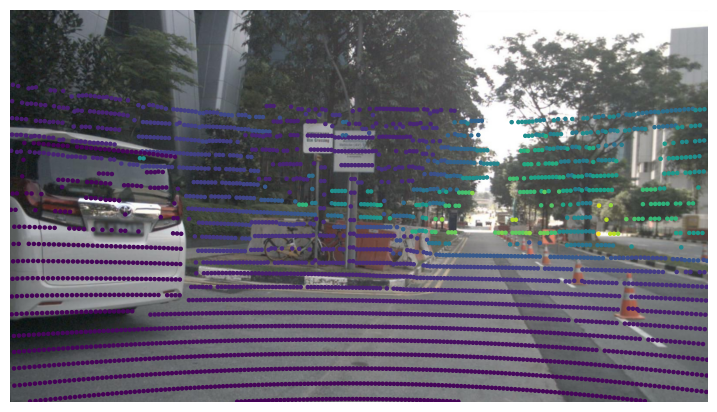

In [10]:
# Using library
# nusc.sample :특정 시점의 단일 샘플
my_sample = nusc.sample[38]
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

# Render point cloud in image step-by-step

In [11]:
sample_token = my_sample['token']
sample_record = nusc.get('sample', sample_token)

In [12]:
##########################################################################
#                     TODO: Implement line                               #
##########################################################################
# Hint : camera_channel : CAM_? (among 6 select one)
pointsensor_channel = 'LIDAR_TOP'
camera_channel = 'CAM_FRONT'
###########################################################################
#                            END OF YOUR CODE                             #
###########################################################################
pointsensor_token = sample_record['data'][pointsensor_channel]
camera_token = sample_record['data'][camera_channel]
print(f"pointsensor_token: {pointsensor_token}, camera_token: {camera_token}")

pointsensor_token: 202d8a4cc24045a08f6ece5876b42d5c, camera_token: bf8c213cfaad4861907cd2677dc2dbcd


In [13]:
cam = nusc.get('sample_data', camera_token)
pointsensor = nusc.get('sample_data', pointsensor_token)
pointsensor

{'token': '202d8a4cc24045a08f6ece5876b42d5c',
 'sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'ego_pose_token': '202d8a4cc24045a08f6ece5876b42d5c',
 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c',
 'timestamp': 1532402946797517,
 'fileformat': 'pcd',
 'is_key_frame': True,
 'height': 0,
 'width': 0,
 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402946797517.pcd.bin',
 'prev': '6392f5ae51ef46d09fbdbd4f3177adae',
 'next': '',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

In [14]:
pcl_path = os.path.join(nusc.dataroot, pointsensor['filename'])
pcl_path

'./nuscenes/samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402946797517.pcd.bin'

In [15]:
# Load Lidar Pointcloud
pc = LidarPointCloud.from_file(pcl_path)
pc.points.shape

(4, 34720)

(-0.5, 1599.5, 899.5, -0.5)

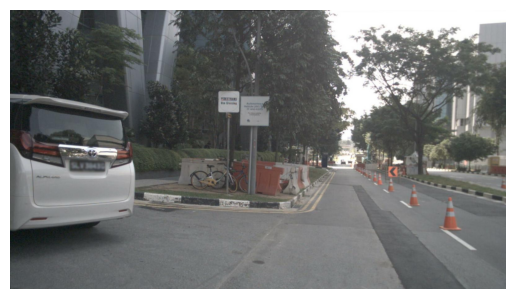

In [16]:
# Load Image
im = Image.open(os.path.join(nusc.dataroot, cam['filename']))
plt.imshow(im)
plt.axis("off")

# Transformation

In [17]:
cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
lidar_to_ego = transform_matrix(translation=cs_record['translation'],
                                rotation=Quaternion(cs_record["rotation"]))

In [18]:
poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
ego_to_global = transform_matrix(translation=poserecord['translation'],
                                rotation=Quaternion(poserecord["rotation"]))

In [19]:
poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
global_to_ego = transform_matrix(translation=poserecord['translation'],
                                rotation=Quaternion(poserecord["rotation"]),
                                inverse=True)

In [20]:
cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
ego_to_camera = transform_matrix(translation=cs_record['translation'],
                                rotation=Quaternion(cs_record["rotation"]),
                                inverse=True)

In [21]:
ego_to_global @ global_to_ego #NOT Identity Matrix!

array([[ 9.99989498e-01, -4.57309160e-03, -2.99855779e-04,
         5.12455597e+00],
       [ 4.57322795e-03,  9.99989439e-01,  4.55611231e-04,
        -1.92568775e+00],
       [ 2.97769061e-04, -4.56977755e-04,  9.99999851e-01,
         3.79577316e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [22]:
##########################################################################
#                     TODO: Implement line                               #
##########################################################################
# Hint : 4 matrix matmul
# Replace ...
TM = ego_to_camera @ global_to_ego @ ego_to_global @ lidar_to_ego
###########################################################################
#                            END OF YOUR CODE                             #
###########################################################################

TM

array([[ 9.99979777e-01, -1.05258914e-03,  6.27198672e-03,
         6.91482487e-03],
       [ 6.28994053e-03,  1.80215355e-02, -9.99817814e-01,
        -3.26303642e-01],
       [ 9.39366537e-04,  9.99837045e-01,  1.80277918e-02,
        -6.89816464e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [23]:
pc = LidarPointCloud.from_file(pcl_path)
pc.points.shape

points = pc.points
points[3, :] = 1
points = np.dot(TM, points)

(-0.5, 1599.5, 899.5, -0.5)

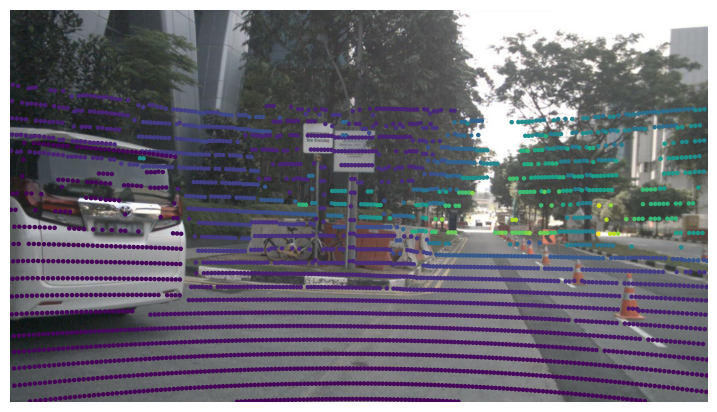

In [24]:
depths = points[2, :]
coloring = depths
view = np.array(cs_record['camera_intrinsic'])
viewpad = np.eye(4)
viewpad[:view.shape[0], :view.shape[1]] = view

points = points[:3, :]
nbr_points = points.shape[1]

points = np.concatenate((points, np.ones((1, nbr_points))))
points = np.dot(viewpad, points)
points = points[:3, :]
points = points / points[2:3, :].repeat(3, 0).reshape(3, nbr_points)
mask = np.ones(depths.shape[0], dtype=bool)
mask = np.logical_and(mask, depths > 1)
mask = np.logical_and(mask, points[0, :] > 1)
mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
mask = np.logical_and(mask, points[1, :] > 1)
mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
points = points[:, mask]
coloring = coloring[mask]
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
ax.imshow(im)
ax.scatter(points[0, :], points[1, :], c=coloring, s=5)
ax.axis('off')